In [192]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import csv
import datetime
from dateutil import parser
import dateutil

rawWeek2 = pd.read_csv('turnstile_160910.csv')
rawWeek3 = pd.read_csv('turnstile_160917.csv')
rawWeek1 = pd.read_csv('turnstile_160903.csv')

frames = [rawWeek1,rawWeek2,rawWeek3]

In [233]:
rawDf = pd.concat(frames,axis=0)
rawDf.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,04:00:00,REGULAR,5799463,1966044
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,08:00:00,REGULAR,5799492,1966079
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,12:00:00,REGULAR,5799610,1966155
4,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,16:00:00,REGULAR,5799833,1966214


In [235]:
# rename and remove unneeded columns
rawDf.columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
df=rawDf.drop(['LINENAME', 'DIVISION', 'DESC', 'EXITS'], axis = 1)
#  ex 1 organize data 
ex_1_1 = df.head()
ex_1_1


,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,08/27/2016,00:00:00,5799442
1,A002,R051,02-00-00,59 ST,08/27/2016,04:00:00,5799463
2,A002,R051,02-00-00,59 ST,08/27/2016,08:00:00,5799492
3,A002,R051,02-00-00,59 ST,08/27/2016,12:00:00,5799610
4,A002,R051,02-00-00,59 ST,08/27/2016,16:00:00,5799833


In [236]:
# create a a single column with date and time data
df['DATETIME'] = df.DATE.astype(str).str.cat(df.TIME.astype(str), sep=' ')
df = df[['C/A', 'UNIT', 'SCP', 'STATION','DATE', 'TIME', 'DATETIME','ENTRIES']]
df.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,08/27/2016,00:00:00,08/27/2016 00:00:00,5799442
1,A002,R051,02-00-00,59 ST,08/27/2016,04:00:00,08/27/2016 04:00:00,5799463
2,A002,R051,02-00-00,59 ST,08/27/2016,08:00:00,08/27/2016 08:00:00,5799492
3,A002,R051,02-00-00,59 ST,08/27/2016,12:00:00,08/27/2016 12:00:00,5799610
4,A002,R051,02-00-00,59 ST,08/27/2016,16:00:00,08/27/2016 16:00:00,5799833


In [237]:
# create a parser object to pass to the datetime column to creat time series
dtConvert = lambda x: parser.parse(x)
df['DATETIME'] = df['DATETIME'].map(dtConvert)


In [238]:
# turn data into time series
ex_1_2= df.head()
ex_1_2


,C/A,UNIT,SCP,STATION,DATE,TIME,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,08/27/2016,00:00:00,2016-08-27 00:00:00,5799442
1,A002,R051,02-00-00,59 ST,08/27/2016,04:00:00,2016-08-27 04:00:00,5799463
2,A002,R051,02-00-00,59 ST,08/27/2016,08:00:00,2016-08-27 08:00:00,5799492
3,A002,R051,02-00-00,59 ST,08/27/2016,12:00:00,2016-08-27 12:00:00,5799610
4,A002,R051,02-00-00,59 ST,08/27/2016,16:00:00,2016-08-27 16:00:00,5799833


In [239]:
# creat new frame and convert date column to datetime for 1-3, drop unnecessary cols
dfDate = rawDf.drop(['LINENAME', 'DIVISION', 'DESC', 'EXITS', 'TIME'], axis = 1)
dfDate['DATE'] = dfDate['DATE'].map(dtConvert)

In [240]:
# calculate the entry count as diffrence between shifted entry column, will be off for the first value of each scp
dfEntries = dfDate['ENTRIES'].sub(dfDate['ENTRIES'].shift(), fill_value = 0)
dfEntries.head()

0    5799442
1         21
2         29
3        118
4        223
Name: ENTRIES, dtype: float64

In [241]:
# drop the old entries column and replace it with the diffrence column from above
dfDate = dfDate.drop('ENTRIES', axis = 1)
dfDate = pd.concat([dfDate, dfEntries], axis = 1, join_axes = [dfDate.index])
# concat c/a,unit,and station into a station key for each unique station,unit,ca combo
dfDate['stationKey'] = dfDate['C/A'].astype(str).str.cat(dfDate.UNIT.astype(str),sep=', ').str.cat(dfDate.STATION.astype(str),sep=', ')

In [243]:
# ex 1-3 solution, group by station key, turnstile and date,  sum on result
ex_1_3 = dfDate.groupby(['stationKey','SCP', 'DATE']).ENTRIES.sum().reset_index()
ex_1_3.head()

,stationKey,SCP,DATE,ENTRIES
0,"A002, R051, 59 ST",02-00-00,2016-08-27,5800121
1,"A002, R051, 59 ST",02-00-00,2016-08-28,677
2,"A002, R051, 59 ST",02-00-00,2016-08-29,1538
3,"A002, R051, 59 ST",02-00-00,2016-08-30,1539
4,"A002, R051, 59 ST",02-00-00,2016-08-31,1508


In [244]:
# for graphing we have to deal with the inaccurate values caused by our subtraction,  lets take a look
# at summary statistics so we can get rid of those accurately
ex_1_3.ENTRIES.describe()

count    9.600200e+04
mean     5.785296e-02
std      9.972429e+07
min     -2.147115e+09
25%      1.880000e+02
50%      8.520000e+02
75%      1.828000e+03
max      2.147113e+09
Name: ENTRIES, dtype: float64

In [245]:
# the diffrence between the mx and the 75th quantile is massive,  to get a closer look
# we'll plot quantiles and see where they spike,  this will help us remove outliers
quantiles = [ex_1_3.ENTRIES.quantile(x) for x in [y/1000 for y in range(800,980,5)]]


[2133.0,
 2169.0,
 2204.0,
 2242.0,
 2283.0,
 2323.0,
 2370.8300000000017,
 2416.0,
 2469.0,
 2526.0,
 2577.0,
 2634.0,
 2702.8600000000006,
 2771.0,
 2843.0,
 2921.0,
 3005.0,
 3097.0,
 3197.0,
 3324.0,
 3460.0,
 3620.9049999999988,
 3815.0,
 4109.8300000000163,
 4469.7599999999948,
 5047.9250000000029,
 7239.8600000000151,
 103483.47500000104,
 301439.39999999927,
 605907.73499999079,
 991413.09999999986,
 1354568.1950000015,
 1864254.5199999779,
 2532437.6649999977,
 3425696.5700000119,
 4351459.4499999406]

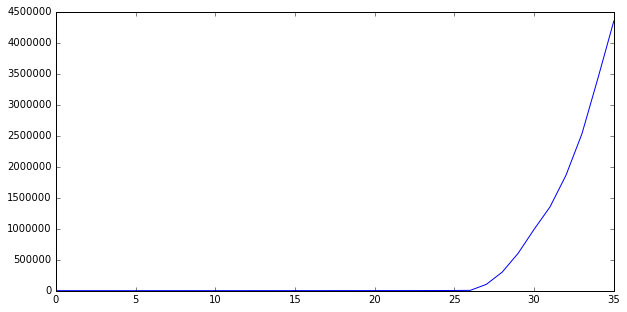

In [246]:
plt.figure(figsize = (10,5))
plt.plot(quantiles)

In [247]:
# as the graph shows, there is a steep increase beginning at the 27th value
quantiles[26]

7239.8600000000151

In [248]:
# we'll get rid of anything higher than 10000 as it's likely do to inaccurate counting, 
# errors in the data, or the effect of the subtraction we did
# anything less than 0 is also likely an error in the data,  that can go too,
# part of this is decided by the quantiles, part by the fact that there are 0nly 86000 seconds in a day,
# and it's very unlikely any 1 turnstile had an entry every 8.6 seconds consistently for 24 hours

ex_1_3 = ex_1_3.loc[(ex_1_3.ENTRIES > 0)&(ex_1_3.ENTRIES < 10000)]
ex_1_3.head()

,stationKey,SCP,DATE,ENTRIES
1,"A002, R051, 59 ST",02-00-00,2016-08-28,677
2,"A002, R051, 59 ST",02-00-00,2016-08-29,1538
3,"A002, R051, 59 ST",02-00-00,2016-08-30,1539
4,"A002, R051, 59 ST",02-00-00,2016-08-31,1508
5,"A002, R051, 59 ST",02-00-00,2016-09-01,1607


In [249]:
# now we filter down to the turnstile level at one station unit to create a plot
ex_1_4 = ex_1_3.loc[(ex_1_3.stationKey=='A002, R051, 59 ST')&(ex_1_3.SCP=='02-00-00')]
ex_1_4.head()

,stationKey,SCP,DATE,ENTRIES
1,"A002, R051, 59 ST",02-00-00,2016-08-28,677
2,"A002, R051, 59 ST",02-00-00,2016-08-29,1538
3,"A002, R051, 59 ST",02-00-00,2016-08-30,1539
4,"A002, R051, 59 ST",02-00-00,2016-08-31,1508
5,"A002, R051, 59 ST",02-00-00,2016-09-01,1607


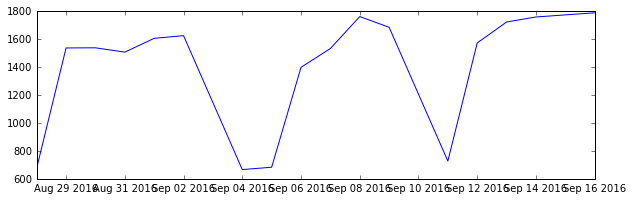

In [250]:
plt.figure(figsize=(10,3))
plt.plot(ex_1_4.DATE,ex_1_4.ENTRIES)

In [251]:
# initialize a new DF transfer values from 1_3, group by station key, sum on entries
# this shows us how many entries happened for 1 day at any 1 station
ex_1_5= pd.DataFrame()
ex_1_5[['stationKey','DATE','ENTRIES']] = ex_1_3[['stationKey','DATE','ENTRIES']]
ex_1_5 = ex_1_5.groupby(['stationKey', 'DATE' ]).ENTRIES.sum().reset_index()
ex_1_5.head(15)

,stationKey,DATE,ENTRIES
0,"A002, R051, 59 ST",2016-08-28,7896
1,"A002, R051, 59 ST",2016-08-29,15462
2,"A002, R051, 59 ST",2016-08-30,16622
3,"A002, R051, 59 ST",2016-08-31,16557
4,"A002, R051, 59 ST",2016-09-01,16464
5,"A002, R051, 59 ST",2016-09-02,15919
6,"A002, R051, 59 ST",2016-09-04,7303
7,"A002, R051, 59 ST",2016-09-05,7105
8,"A002, R051, 59 ST",2016-09-06,15694
9,"A002, R051, 59 ST",2016-09-07,17425


In [252]:
# drill down to the same station we looked at in 1_4
ex_1_6 = ex_1_5.loc[(ex_1_5.stationKey=='A002, R051, 59 ST')]
ex_1_6

,stationKey,DATE,ENTRIES
0,"A002, R051, 59 ST",2016-08-28,7896
1,"A002, R051, 59 ST",2016-08-29,15462
2,"A002, R051, 59 ST",2016-08-30,16622
3,"A002, R051, 59 ST",2016-08-31,16557
4,"A002, R051, 59 ST",2016-09-01,16464
5,"A002, R051, 59 ST",2016-09-02,15919
6,"A002, R051, 59 ST",2016-09-04,7303
7,"A002, R051, 59 ST",2016-09-05,7105
8,"A002, R051, 59 ST",2016-09-06,15694
9,"A002, R051, 59 ST",2016-09-07,17425


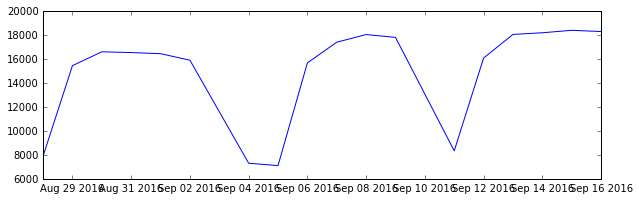

In [253]:
# ex_1_7 plot timeseries for 1 station for all weeks sampled
plt.figure(figsize=(10,3))
plt.plot(ex_1_6.DATE,ex_1_6.ENTRIES);

In [280]:
# creat a new frame, fill with values from 1_5 
ex_1_8 = pd.DataFrame()
ex_1_8[['stationKey','DATE','ENTRIES']] = ex_1_5[['stationKey','DATE','ENTRIES']] 

# add week of year so we can filter on that condition
ex_1_8['weekOfYear'] = ex_1_8.DATE.dt.weekofyear
ex_1_8 = ex_1_8.groupby(['stationKey', 'DATE', 'weekOfYear' ]).ENTRIES.sum().reset_index()

# create a view from which we can plot 1 week at 1 station
ex8 = ex_1_8.loc[(ex_1_8.weekOfYear ==36)&(ex_1_8.stationKey =='A002, R051, 59 ST')]
ex8.head()

,stationKey,DATE,weekOfYear,ENTRIES
7,"A002, R051, 59 ST",2016-09-05,36,7105
8,"A002, R051, 59 ST",2016-09-06,36,15694
9,"A002, R051, 59 ST",2016-09-07,36,17425
10,"A002, R051, 59 ST",2016-09-08,36,18063
11,"A002, R051, 59 ST",2016-09-09,36,17826


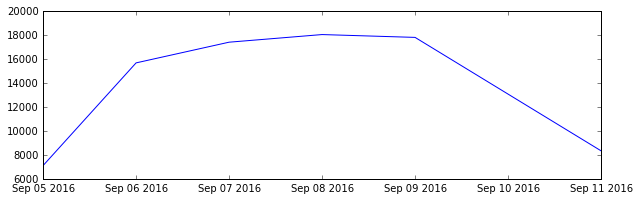

In [281]:
plt.figure(figsize=(10,3))
plt.plot(ex8.DATE,ex8.ENTRIES)

In [303]:

# group by stations and sum on entries over multiple weeks, sort entry counts descending

ex_1_9 = ex_1_8.groupby(['stationKey']).ENTRIES.sum().reset_index()
ex_1_9.sort_values('ENTRIES',ascending=False,inplace=True)
ex_1_9.head(15)


,stationKey,ENTRIES
551,"R238, R046, GRD CNTRL-42 ST",901456
566,"R250, R179, 86 ST",778083
474,"R138, R293, 34 ST-PENN STA",740592
677,"R533, R055, FLUSHING-MAIN",730308
325,"N324, R018, JKSN HT-ROOSVLT",631043
206,"N051, R084, 59 ST COLUMBUS",614099
553,"R240, R047, GRD CNTRL-42 ST",608726
562,"R246, R177, 68ST-HUNTER CO",551843
371,"N506, R022, 34 ST-HERALD SQ",547840
536,"R221, R170, 14 ST-UNION SQ",534249


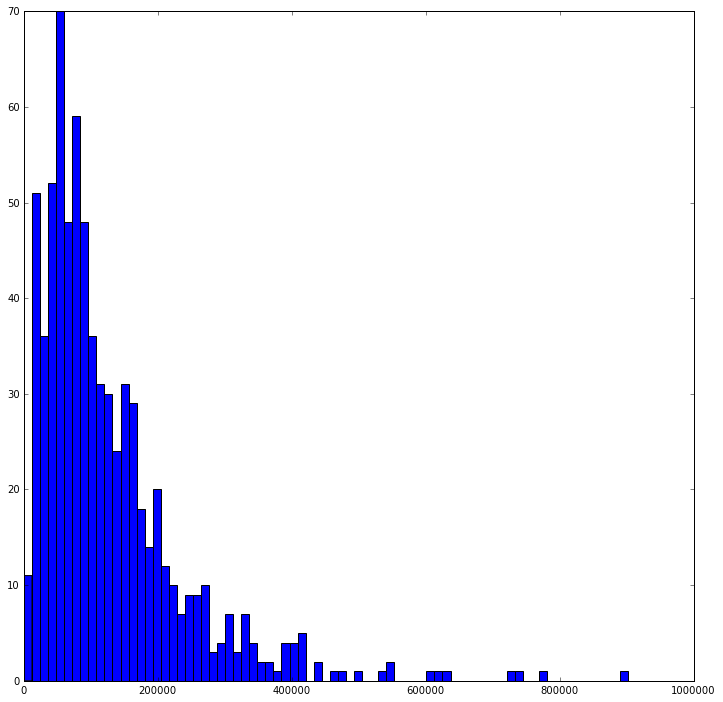

In [304]:
# create a histogram of total entry counts 
ex_1_10 = ex_1_9.ENTRIES
plt.figure(figsize = (12, 12))
plt.hist(ex_1_10,bins=75);